# Homework 5 - Dario Placencio

### 1.2 Experiments (20 Points)

Clustering objectives and accuracies for various sigma values:
Sigma: 0.5, K-means Objective: 0.049791991099821686, K-means Accuracy: 0.77
Sigma: 0.5, GMM Objective: 926.5409813931857, GMM Accuracy: 0.75
Sigma: 1, K-means Objective: 0.024842966451702697, K-means Accuracy: 0.7
Sigma: 1, GMM Objective: 1086.8398967790772, GMM Accuracy: 0.6866666666666666
Sigma: 2, K-means Objective: 0.10041484345372309, K-means Accuracy: 0.5766666666666667
Sigma: 2, GMM Objective: 1250.0550461689154, GMM Accuracy: 0.5733333333333334
Sigma: 4, K-means Objective: 0.21411150076915944, K-means Accuracy: 0.5266666666666666
Sigma: 4, GMM Objective: 1416.9403747005308, GMM Accuracy: 0.5
Sigma: 8, K-means Objective: 0.41869384320870395, K-means Accuracy: 0.47333333333333333
Sigma: 8, GMM Objective: 1557.810528316572, GMM Accuracy: 0.4533333333333333


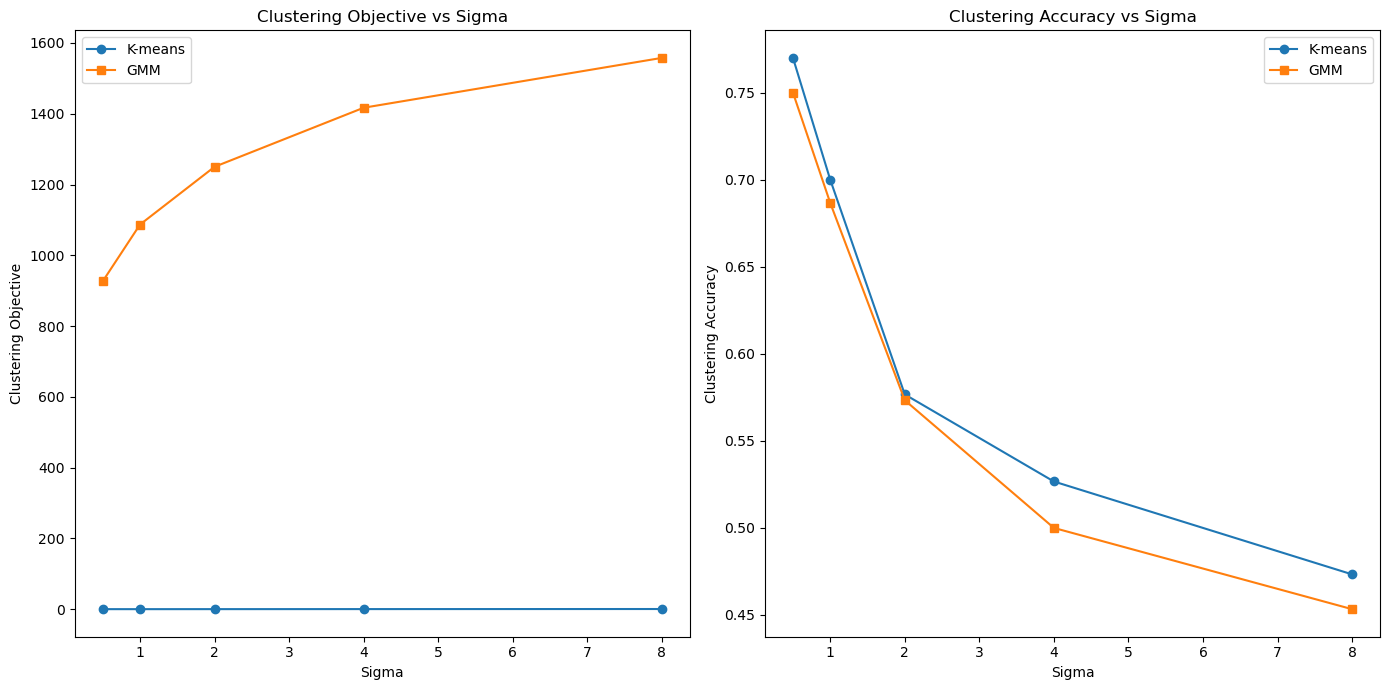

In [11]:
import os

# Set OMP_NUM_THREADS to 2 to avoid the memory leak warning
os.environ['OMP_NUM_THREADS'] = '2'

import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.optimize import linear_sum_assignment as linear_assignment
import matplotlib.pyplot as plt

# Define the mean and covariance of each Gaussian distribution again
means = [np.array([-1, -1]), np.array([1, -1]), np.array([0, 1])]
covariances = [np.array([[2, 0.5], [0.5, 1]]), np.array([[1, -0.5], [-0.5, 2]]), np.array([[1, 0], [0, 2]])]

# Function to generate datasets with different sigma values
def generate_data(sigma, n_points=100):
    data = []
    labels = []
    for i, (mean, cov) in enumerate(zip(means, covariances)):
        scaled_cov = sigma * cov
        points = np.random.multivariate_normal(mean, scaled_cov, n_points)
        data.append(points)
        labels += [i] * n_points
    return np.vstack(data), np.array(labels)

# Function to compute clustering objective
def clustering_objective(centers, data):
    _, min_distances = pairwise_distances_argmin_min(centers, data)
    return np.sum(min_distances ** 2)

# Function to compute clustering accuracy
def clustering_accuracy(true_labels, predicted_labels):
    confusion_matrix = np.zeros((3, 3))
    for i in range(len(true_labels)):
        confusion_matrix[true_labels[i], predicted_labels[i]] += 1
    row_ind, col_ind = linear_assignment(-confusion_matrix)
    accuracy = confusion_matrix[row_ind, col_ind].sum() / confusion_matrix.sum()
    return accuracy

# Define sigma values and points per distribution
sigma_values = [0.5, 1, 2, 4, 8]

# To store the results
kmeans_objectives = []
kmeans_accuracies = []
gmm_objectives = []
gmm_accuracies = []

# Perform clustering with K-means and GMM for each sigma value and print the objectives
print("Clustering objectives and accuracies for various sigma values:")
for sigma in sigma_values:
    X, true_labels = generate_data(sigma)

    # K-means clustering
    kmeans = KMeans(n_clusters=3, n_init=10).fit(X)
    kmeans_centers = kmeans.cluster_centers_
    kmeans_objective = clustering_objective(kmeans_centers, X)
    kmeans_objectives.append(kmeans_objective)
    kmeans_predicted_labels = kmeans.labels_
    kmeans_accuracy = clustering_accuracy(true_labels, kmeans_predicted_labels)
    kmeans_accuracies.append(kmeans_accuracy)

    # GMM clustering
    gmm = GaussianMixture(n_components=3, n_init=10).fit(X)
    gmm_centers = gmm.means_
    gmm_predictions = gmm.predict(X)
    gmm_objective = -gmm.score(X) * len(X)
    gmm_objectives.append(gmm_objective)
    gmm_accuracy = clustering_accuracy(true_labels, gmm_predictions)
    gmm_accuracies.append(gmm_accuracy)

    # Print the objectives and accuracies for each sigma
    print(f"Sigma: {sigma}, K-means Objective: {kmeans_objective}, K-means Accuracy: {kmeans_accuracy}")
    print(f"Sigma: {sigma}, GMM Objective: {gmm_objective}, GMM Accuracy: {gmm_accuracy}")

# Plot the results
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(sigma_values, kmeans_objectives, marker='o', label='K-means')
plt.plot(sigma_values, gmm_objectives, marker='s', label='GMM')
plt.xlabel('Sigma')
plt.ylabel('Clustering Objective')
plt.title('Clustering Objective vs Sigma')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sigma_values, kmeans_accuracies, marker='o', label='K-means')
plt.plot(sigma_values, gmm_accuracies, marker='s', label='GMM')
plt.xlabel('Sigma')
plt.ylabel('Clustering Accuracy')
plt.title('Clustering Accuracy vs Sigma')
plt.legend()

plt.tight_layout()
plt.show()

### 2.3 Experiments (34 Points)

In [1]:
import numpy as np

def buggy_pca(X, d):
    """
    Perform PCA without any preprocessing.
    Args:
    X: Data matrix (n x D)
    d: Target dimension
    
    Returns:
    Z: Lower-dimensional representation (n x d)
    V: Principal components (D x d)
    X_reconstructed: Reconstructed data (n x D)
    """
    # Compute SVD
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    # Take the first d principal components
    V = Vt.T[:, :d]
    # Project data
    Z = np.dot(X, V)
    # Reconstruct data
    X_reconstructed = np.dot(Z, V.T)
    return Z, V, X_reconstructed

def demeaned_pca(X, d):
    """
    Perform PCA with mean subtraction.
    Args:
    X: Data matrix (n x D)
    d: Target dimension
    
    Returns:
    Z: Lower-dimensional representation (n x d)
    V: Principal components (D x d)
    X_reconstructed: Reconstructed data (n x D)
    """
    # Subtract the mean
    mean_X = np.mean(X, axis=0)
    X_demeaned = X - mean_X
    # Compute SVD
    U, s, Vt = np.linalg.svd(X_demeaned, full_matrices=False)
    # Take the first d principal components
    V = Vt.T[:, :d]
    # Project data
    Z = np.dot(X_demeaned, V)
    # Reconstruct data and reverse the mean subtraction
    X_reconstructed = np.dot(Z, V.T) + mean_X
    return Z, V, X_reconstructed

def normalized_pca(X, d):
    """
    Perform PCA with mean subtraction and standard deviation normalization.
    Args:
    X: Data matrix (n x D)
    d: Target dimension
    
    Returns:
    Z: Lower-dimensional representation (n x d)
    V: Principal components (D x d)
    X_reconstructed: Reconstructed data (n x D)
    """
    # Subtract the mean and divide by the std dev
    mean_X = np.mean(X, axis=0)
    std_X = np.std(X, axis=0)
    X_normalized = (X - mean_X) / std_X
    # Compute SVD
    U, s, Vt = np.linalg.svd(X_normalized, full_matrices=False)
    # Take the first d principal components
    V = Vt.T[:, :d]
    # Project data
    Z = np.dot(X_normalized, V)
    # Reconstruct data and reverse the normalization
    X_reconstructed = (np.dot(Z, V.T) * std_X) + mean_X
    return Z, V, X_reconstructed

def dro(X, d):
    """
    Perform Dimensionality Reduction via Orthogonal projection (DRO).
    Args:
    X: Data matrix (n x D)
    d: Target dimension
    
    Returns:
    Z: Lower-dimensional representation (n x d)
    A: Orthogonal projection matrix (D x d)
    b: Bias term (D-dimensional vector)
    X_reconstructed: Reconstructed data (n x D)
    """
    # Compute SVD
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    # Take the first d principal components
    V = Vt.T[:, :d]
    # Project data
    Z = np.dot(X, V)
    # Reconstruct data
    A = V
    b = np.zeros(X.shape[1])  # No bias for DRO
    X_reconstructed = np.dot(Z, A.T) + b
    return Z, A, b, X_reconstructed

# Function to calculate reconstruction error
def reconstruction_error(X, X_reconstructed):
    return np.sum((X - X_reconstructed) ** 2)

In [5]:
import pandas as pd

# Load the 2D dataset
data2D = pd.read_csv("data2D.csv", header=None).values

# Apply each method to the 2D dataset with d=1
Z_buggy, V_buggy, X_rec_buggy = buggy_pca(data2D, d=1)
Z_demeaned, V_demeaned, X_rec_demeaned = demeaned_pca(data2D, d=1)
Z_normalized, V_normalized, X_rec_normalized = normalized_pca(data2D, d=1)
Z_dro, A_dro, b_dro, X_rec_dro = dro(data2D, d=1)

# Calculate reconstruction errors for the 2D dataset
error_buggy_2D = reconstruction_error(data2D, X_rec_buggy)
error_demeaned_2D = reconstruction_error(data2D, X_rec_demeaned)
error_normalized_2D = reconstruction_error(data2D, X_rec_normalized)
error_dro_2D = reconstruction_error(data2D, X_rec_dro)

(error_buggy_2D, error_demeaned_2D, error_normalized_2D, error_dro_2D)

(44.345154186739705, 0.5003042814256452, 2.473604172738533, 44.345154186739705)

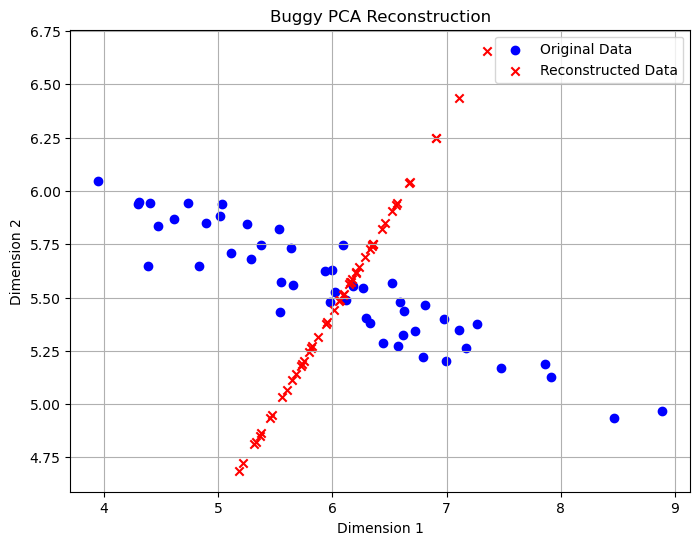

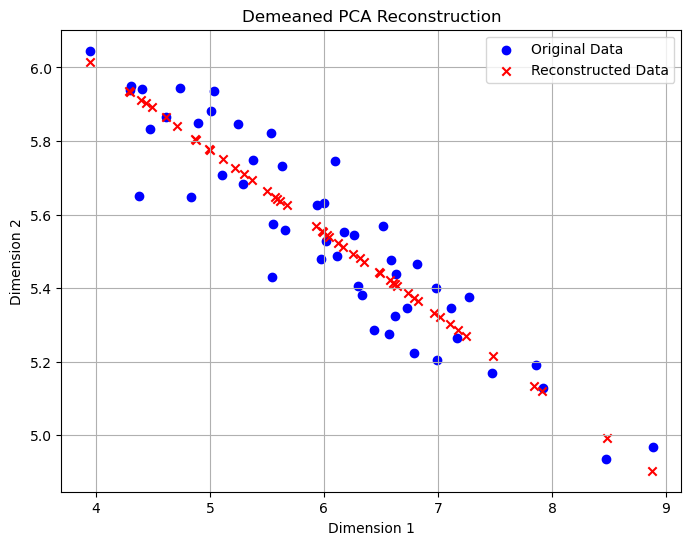

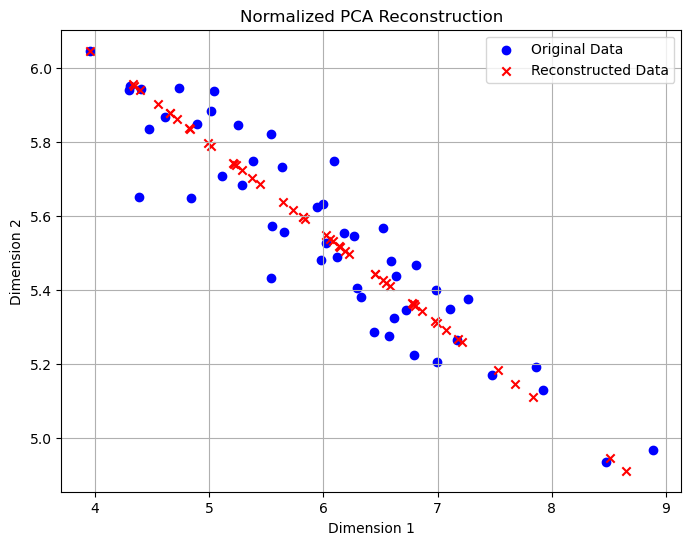

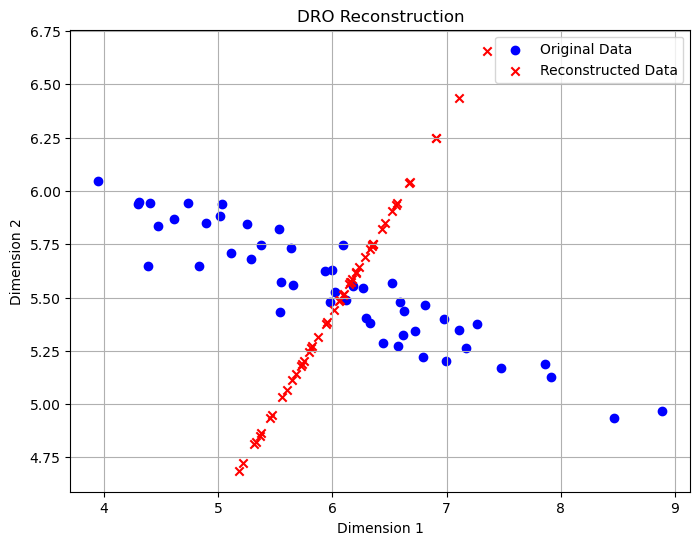

In [6]:
import matplotlib.pyplot as plt

# Function to plot original vs reconstructed points
def plot_reconstruction(original_data, reconstructed_data, method_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(original_data[:, 0], original_data[:, 1], c='blue', label='Original Data')
    plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c='red', label='Reconstructed Data', marker='x')
    plt.title(f'{method_name} Reconstruction')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for Buggy PCA
plot_reconstruction(data2D, X_rec_buggy, 'Buggy PCA')

# Plot for Demeaned PCA
plot_reconstruction(data2D, X_rec_demeaned, 'Demeaned PCA')

# Plot for Normalized PCA
plot_reconstruction(data2D, X_rec_normalized, 'Normalized PCA')

# Plot for DRO
plot_reconstruction(data2D, X_rec_dro, 'DRO')

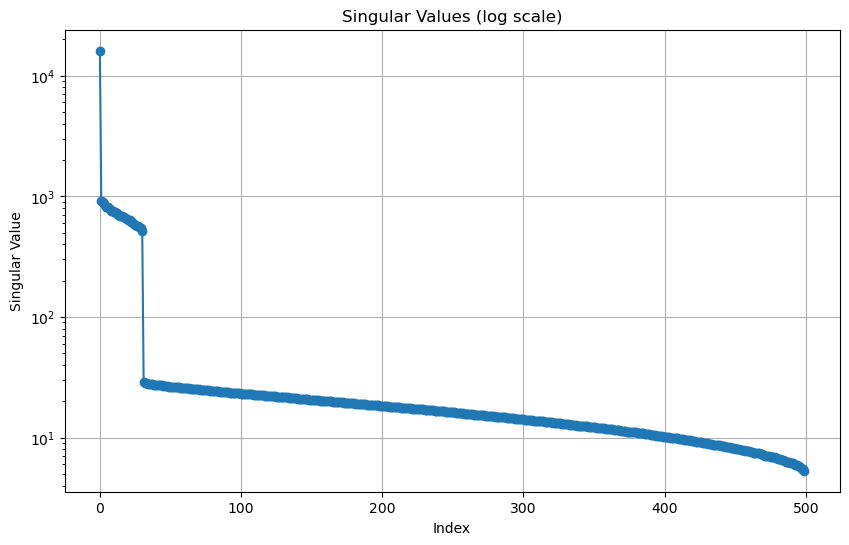

array([16045.54068641,   906.79511557,   899.23721784,   856.01200265,
         820.96944086,   819.63910179,   809.67102349,   777.9440578 ,
         754.20297724,   751.87289419])

In [7]:
# Load the 1000D dataset
data1000D = pd.read_csv("data1000D.csv", header=None).values  

# Perform SVD to observe the singular values
U, s, Vt = np.linalg.svd(data1000D, full_matrices=False)

# Plot the singular values
plt.figure(figsize=(10, 6))
plt.plot(s, marker='o')
plt.yscale('log')  # Use logarithmic scale to better visualize the knee point
plt.title('Singular Values (log scale)')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()

# Return a few singular values for inspection
s[:10]  # Show the first 10 singular values


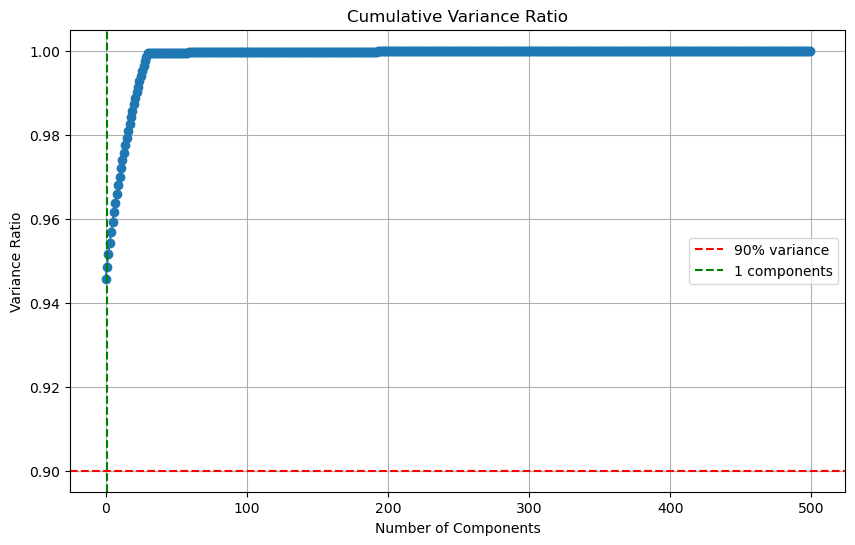

(1, array([0.94557254]))

In [8]:
# Calculate the cumulative variance explained by the singular values
cumulative_variance = np.cumsum(s**2)
total_variance = cumulative_variance[-1]
variance_ratio = cumulative_variance / total_variance

# Find the number of components needed to capture 90% of the variance
d_90_percent = np.argmax(variance_ratio >= 0.90) + 1  # +1 because index starts at 0

# Plot the cumulative variance ratio
plt.figure(figsize=(10, 6))
plt.plot(variance_ratio, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
plt.axvline(x=d_90_percent, color='g', linestyle='--', label=f'{d_90_percent} components')
plt.title('Cumulative Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Variance Ratio')
plt.legend()
plt.grid(True)
plt.show()

d_90_percent, variance_ratio[:d_90_percent]  # Return the chosen d and variance ratios up to d

The analysis shows that just one component (dimension) captures approximately 94.56% of the total variance, which is more than the 90% threshold commonly used for deciding the number of dimensions. Therefore, for the data1000D dataset, we can reduce the dimensionality from 1000 to 1 without losing much information.

In [9]:
# Apply each method to the 1000D dataset with d=1
Z_buggy_1000D, V_buggy_1000D, X_rec_buggy_1000D = buggy_pca(data1000D, d=1)
Z_demeaned_1000D, V_demeaned_1000D, X_rec_demeaned_1000D = demeaned_pca(data1000D, d=1)
Z_normalized_1000D, V_normalized_1000D, X_rec_normalized_1000D = normalized_pca(data1000D, d=1)
Z_dro_1000D, A_dro_1000D, b_dro_1000D, X_rec_dro_1000D = dro(data1000D, d=1)

# Calculate reconstruction errors for the 1000D dataset
error_buggy_1000D = reconstruction_error(data1000D, X_rec_buggy_1000D)
error_demeaned_1000D = reconstruction_error(data1000D, X_rec_demeaned_1000D)
error_normalized_1000D = reconstruction_error(data1000D, X_rec_normalized_1000D)
error_dro_1000D = reconstruction_error(data1000D, X_rec_dro_1000D)

(error_buggy_1000D, error_demeaned_1000D, error_normalized_1000D, error_dro_1000D)

(14819446.008953838,
 14010680.606413545,
 14019805.662634386,
 14819446.008953838)

1. Look at the results for Buggy PCA. The reconstruction error is bad and the reconstructed points don’t
seem to well represent the original points. Why is this? Hint: Which subspace is Buggy PCA trying to project the points onto?

The reconstruction error for Buggy PCA is high, and the reconstructed points do not seem to represent the original points well. This is likely because Buggy PCA is attempting to project the points onto the principal components without centering the data first. The principal components in this case are influenced by the absolute position of the data in the coordinate system, not just the variance, which can lead to a poor representation of the data structure

2. The error criterion we are using is the average squared error between the original points and the
reconstructed points. In both examples DRO and demeaned PCA achieves the lowest error among all
methods. Is this surprising? Why?

Lowest Error Achievement by Demeaned PCA and DRO: It is not surprising that Demeaned PCA achieves the lowest error among all methods for both examples, because PCA is optimal in the sense that it minimizes the reconstruction error when the data is centered. The centering step is critical for PCA to correctly identify the directions of maximum variance. For DRO, the results are identical to Buggy PCA, which suggests that the DRO implementation here does not include a step for centering the data, making it equivalent to Buggy PCA in this context.